In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import cv2
import os
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import figure

This dataset was taken from the official [NIH Website](https://ceb.nlm.nih.gov/repositories/malaria-datasets/). It consists of 2 folders (Parasitezed and Uninfected) with a total of 27,558 images.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

# Dataset Overview

In [2]:
data_dir = pathlib.Path('../input/cell-images-for-detecting-malaria/cell_images/cell_images')

Checking data. You should now have a copy of the dataset available with 27558 total images

In [4]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27558


First visualizations. We can see clear differences in the morphology of parasitized cells.

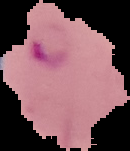

In [5]:
parasitized = list(data_dir.glob('Parasitized/*'))
PIL.Image.open(str(parasitized[0]))

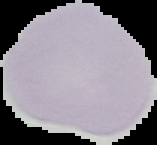

In [6]:
uninfected = list(data_dir.glob('Uninfected/*'))
PIL.Image.open(str(uninfected[0]))

# Data Loading
### Creating Dataset

In [7]:
batch_size = 128
img_height = 150
img_width = 150

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


We can check the class names.

In [11]:
class_names = train_ds.class_names
print(class_names)

['Parasitized', 'Uninfected']


### Configure the dataset for performance

**from tensorflow guide**
* `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* `Dataset.prefetch` overlaps data preprocessing and model execution while training.


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model
The data has been rescaled for performance (1./255) directly in the first layer of the model

In [20]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        1

In [ ]:
# uncomment for model schematics
# from tensorflow.keras.utils import to_categorical, plot_model
# plt.figure(figsize=(5, 10))
# plot_model(model)

In [21]:
tf.keras.backend.clear_session()

In [22]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds,epochs=epochs, verbose=1)

Epoch 1/10
173/173 [==============================] - 131s 752ms/step - loss: 0.6479 - accuracy: 0.6278 - val_loss: 0.5537 - val_accuracy: 0.7320
Epoch 2/10
173/173 [==============================] - 133s 771ms/step - loss: 0.3677 - accuracy: 0.8465 - val_loss: 0.2193 - val_accuracy: 0.9327
Epoch 3/10
173/173 [==============================] - 130s 754ms/step - loss: 0.2038 - accuracy: 0.9288 - val_loss: 0.2007 - val_accuracy: 0.9354
Epoch 4/10
173/173 [==============================] - 127s 737ms/step - loss: 0.1839 - accuracy: 0.9340 - val_loss: 0.1720 - val_accuracy: 0.9387
Epoch 5/10
173/173 [==============================] - 131s 757ms/step - loss: 0.1697 - accuracy: 0.9354 - val_loss: 0.1838 - val_accuracy: 0.9372
Epoch 6/10
173/173 [==============================] - 124s 719ms/step - loss: 0.1546 - accuracy: 0.9455 - val_loss: 0.1543 - val_accuracy: 0.9521
Epoch 7/10
173/173 [==============================] - 127s 735ms/step - loss: 0.1425 - accuracy: 0.9511 - val_loss: 0.1508 -

### Visualize training results
We can plot the model metrics for a clear understanding of the training evolution over the epochs.

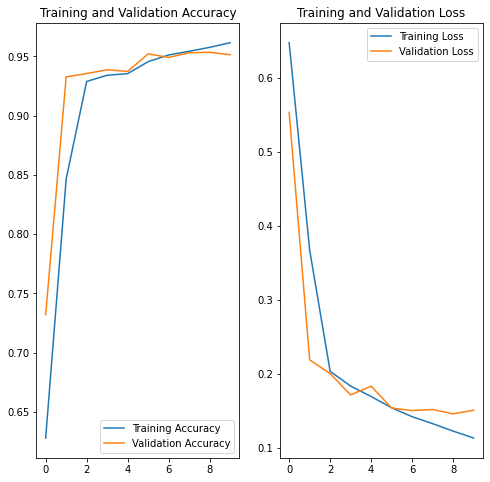

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Implementing Data Augmentation

In [25]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [26]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])

In [27]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds,epochs=epochs, verbose=1)

Epoch 1/10
173/173 [==============================] - 166s 955ms/step - loss: 0.4869 - accuracy: 0.7522 - val_loss: 0.2173 - val_accuracy: 0.9278
Epoch 2/10
173/173 [==============================] - 167s 966ms/step - loss: 0.2165 - accuracy: 0.9243 - val_loss: 0.1720 - val_accuracy: 0.9345
Epoch 3/10
173/173 [==============================] - 167s 967ms/step - loss: 0.1828 - accuracy: 0.9390 - val_loss: 0.1569 - val_accuracy: 0.9483
Epoch 4/10
173/173 [==============================] - 160s 925ms/step - loss: 0.1736 - accuracy: 0.9423 - val_loss: 0.1506 - val_accuracy: 0.9523
Epoch 5/10
173/173 [==============================] - 162s 937ms/step - loss: 0.1561 - accuracy: 0.9497 - val_loss: 0.1515 - val_accuracy: 0.9545
Epoch 6/10
173/173 [==============================] - 160s 927ms/step - loss: 0.1477 - accuracy: 0.9527 - val_loss: 0.1479 - val_accuracy: 0.9525
Epoch 7/10
173/173 [==============================] - 160s 924ms/step - loss: 0.1389 - accuracy: 0.9551 - val_loss: 0.1286 -

### Visualize training results - Data Augmentation
Create visuals for the data augmentation model performance

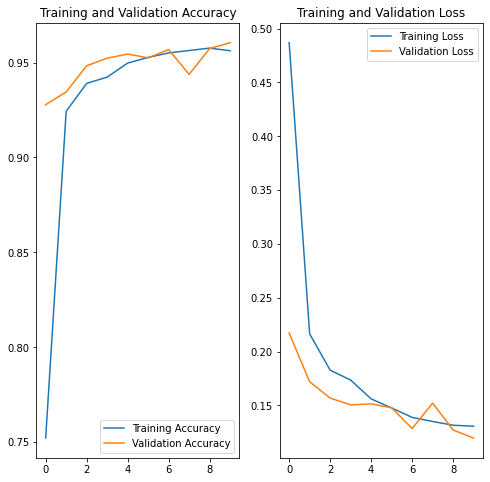

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()